## Processing Ocean Color Imagery - Process Micasense Images

Pull in all images and process with micasense tools
    normalize and align and whatnot
    put these into functions and clean up
    also visualize along the way and look at distributions to think about whether or not they're legitimate
    write out
    
Pull in all images as modified and metadata with specific functions
    Visualize for issues and shadows and bright spots and locations
    correct for sky radiance
    visualize the distributions of both sky (clouds) and sea
    look at the variability of spectra both for specific pixels and across nearby images
    filter for orientation and location and issues

take the water leaving spectra and convert to chla as well as other future products and just intro general analysis of spectra
    produce a csv or .shp or images of ocean color products 
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
from micasense import imageset as imageset
from micasense import capture as capture
import os, glob
import multiprocessing

import cv2
import numpy as np
import matplotlib.pyplot as plt


import micasense.imageutils as imageutils
import micasense.plotutils as plotutils

import exiftool
import datetime

import subprocess

### Helper Functions

In [14]:
def process_panel_img(panelNames, useDLS = True):
    location = None
    utc_time = None
    if panelNames is not None:
        panelCap = capture.Capture.from_filelist(panelNames)
        location = panelCap.location()
        utc_time = panelCap.utc_time()
    else:
        panelCap = None

    if panelCap is not None:
        if panelCap.panel_albedo() is not None and not any(v is None for v in panelCap.panel_albedo()):
            panel_reflectance_by_band = panelCap.panel_albedo()
        else:
            panel_reflectance_by_band = [0.67, 0.69, 0.68, 0.61, 0.67] #RedEdge band_index order

        panel_irradiance = panelCap.panel_irradiance(panel_reflectance_by_band)    
        img_type = "reflectance"
    else:
        if useDLS:
            img_type='reflectance'
        else:
            img_type = "radiance"
    return(panel_irradiance, img_type, location, utc_time)

In [54]:
def get_warp_matrix(img_capture, max_alignment_iterations = 10):
    # TODO does this need img_type???
    # TODO ensure this is good for the Altum
    ## Alignment settings
    match_index = 1 # Index of the band 
    warp_mode = cv2.MOTION_HOMOGRAPHY # MOTION_HOMOGRAPHY or MOTION_AFFINE. For Altum images only use HOMOGRAPHY
    pyramid_levels = 0 # for images with RigRelatives, setting this to 0 or 1 may improve alignment
    print("Aligning images. Depending on settings this can take from a few seconds to many minutes")
    # Can potentially increase max_iterations for better results, but longer runtimes
    warp_matrices, alignment_pairs = imageutils.align_capture(img_capture,
                                                              ref_index = match_index,
                                                              max_iterations = max_alignment_iterations,
                                                              warp_mode = warp_mode,
                                                              pyramid_levels = pyramid_levels)

    #print("Finished Aligning, warp matrices={}".format(warp_matrices))
    return(warp_matrices)



In [16]:
def decdeg2dms(dd):
    is_positive = dd >= 0
    dd = abs(dd)
    minutes,seconds = divmod(dd*3600,60)
    degrees,minutes = divmod(minutes,60)
    degrees = degrees if is_positive else -degrees
    return (degrees,minutes,seconds)


def write_exif_csv(img_set, outputPath):
    header = "SourceFile,\
    GPSDateStamp,GPSTimeStamp,\
    GPSLatitude,GpsLatitudeRef,\
    GPSLongitude,GPSLongitudeRef,\
    GPSAltitude,GPSAltitudeRef,\
    FocalLength,\
    XResolution,YResolution,ResolutionUnits\n"

    lines = [header]
    for capture in img_set.captures:
        #get lat,lon,alt,time
        outputFilename = capture.uuid+'.tif'
        fullOutputPath = os.path.join(outputPath, outputFilename)
        lat,lon,alt = capture.location()
        #write to csv in format:
        # IMG_0199_1.tif,"33 deg 32' 9.73"" N","111 deg 51' 1.41"" W",526 m Above Sea Level
        latdeg, latmin, latsec = decdeg2dms(lat)
        londeg, lonmin, lonsec = decdeg2dms(lon)
        latdir = 'North'
        if latdeg < 0:
            latdeg = -latdeg
            latdir = 'South'
        londir = 'East'
        if londeg < 0:
            londeg = -londeg
            londir = 'West'
        resolution = capture.images[0].focal_plane_resolution_px_per_mm

        linestr = '"{}",'.format(fullOutputPath)
        linestr += capture.utc_time().strftime("%Y:%m:%d,%H:%M:%S,")
        linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},'.format(int(latdeg),int(latmin),latsec,latdir[0],latdir)
        linestr += '"{:d} deg {:d}\' {:.2f}"" {}",{},{:.1f} m Above Sea Level,Above Sea Level,'.format(int(londeg),int(lonmin),lonsec,londir[0],londir,alt)
        linestr += '{}'.format(capture.images[0].focal_length)
        linestr += '{},{},mm'.format(resolution,resolution)
        linestr += '\n' # when writing in text mode, the write command will convert to os.linesep
        lines.append(linestr)

    fullCsvPath = os.path.join(outputPath,'log.csv')
    with open(fullCsvPath, 'w') as csvfile: #create CSV
        csvfile.writelines(lines)
        
    return(fullCsvPath)

In [45]:
def save_images(img_set, outputPath, thumbnailPath, panel_irradiance, generateThumbnails = True, overwrite=False):
    """
    This function does ther actual processing of running through each capture within an imageset
    and saving as a .tiff.
    
    TODO change this to save images with rasterio as proper rasters
        only really necessary if we're going to map as opposed to use imgs as samples
    """
    # TODO this isn't working, these image alignments are terrible...
    warp_matrices = get_warp_matrix(img_set.captures[0])

    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    if generateThumbnails and not os.path.exists(thumbnailPath):
        os.makedirs(thumbnailPath)

    # Save out geojson data so we can open the image capture locations in our GIS
    # with open(os.path.join(outputPath,'imageSet.json'),'w') as f:
    #     f.write(str(geojson_data))

    try:
        irradiance = panel_irradiance+[0]
    except NameError:
        irradiance = None

    start = datetime.datetime.now()
    for i,capture in enumerate(img_set.captures):
        outputFilename = capture.uuid+'.tif'
        thumbnailFilename = capture.uuid+'.jpg'
        fullOutputPath = os.path.join(outputPath, outputFilename)
        fullThumbnailPath= os.path.join(thumbnailPath, thumbnailFilename)
        if (not os.path.exists(fullOutputPath)) or overwrite:
            if(len(capture.images) == len(img_set.captures[0].images)):
                capture.compute_undistorted_reflectance(irradiance_list=panel_irradiance,force_recompute=True)
                capture.create_aligned_capture(irradiance_list=panel_irradiance, warp_matrices=warp_matrices)
                capture.save_capture_as_stack(fullOutputPath, sort_by_wavelength=True)
                if generateThumbnails:
                    capture.save_capture_as_rgb(fullThumbnailPath)
        capture.clear_image_data()
    end = datetime.datetime.now()

    print("Saving time: {}".format(end-start))
    print("Alignment+Saving rate: {:.2f} images per second".format(float(len(img_set.captures))/float((end-start).total_seconds())))
    return(True)

In [46]:
def write_img_exif(fullCsvPath, outputPath):  
    if os.environ.get('exiftoolpath') is not None:
        exiftool_cmd = os.path.normpath(os.environ.get('exiftoolpath'))
    else:
        exiftool_cmd = 'exiftool'

    cmd = '{} -csv="{}" -overwrite_original {}'.format(exiftool_cmd, fullCsvPath, outputPath)
    print(cmd)
    #subprocess.check_call(cmd)
    return(True)

In [47]:
# TODO could make a function that splits the full images up into panel and sea and sky

### Primary Processing Function

In [48]:
def process_micasense_images(sea_dir, sky_dir, panelNames, overwrite=False):
    """
    Primary function that takes in sea and sky image directories and saves out processed imagery
    
    Various visualization functions for deciding ideal processing parameters
    
    """
    # ideally this goes through and picks out all panels and then chooses the closest one
    # right now it just takes one
    panel_irradiance, img_type, location, utc_time = process_panel_img(panelNames)
    print("Panel irradiance calculated.")
    
    # also will need to integrate the DLS as an alternative
    
    seaimgset = imageset.ImageSet.from_directory(sea_dir)
    seaOutputPath = os.path.join(sea_dir,'..','seastacks')
    seathumbnailPath = os.path.join(sea_dir, '..', 'seathumbnails')
    
    skyimgset = imageset.ImageSet.from_directory(sky_dir)
    skyOutputPath = os.path.join(sky_dir,'..','skystacks')
    skythumbnailPath = os.path.join(sky_dir, '..', 'skythumbnails')
    
    if save_images(seaimgset, seaOutputPath, seathumbnailPath, panel_irradiance, overwrite=overwrite) == True:
        print("Finished saving sea images.")
        fullCsvPath = write_exif_csv(seaimgset, seaOutputPath)
        if write_img_exif(fullCsvPath, seaOutputPath) == True:
            print("Finished saving sea image metadata.")
        
    if save_images(skyimgset, skyOutputPath, skythumbnailPath, panel_irradiance, overwrite=overwrite) == True:
        print("Finished saving sky images.")
        fullCsvPath = write_exif_csv(skyimgset, skyOutputPath)
        if write_img_exif(fullCsvPath, skyOutputPath) == True:        
            print("Finished saving sky image metadata.")
            
    return(seaOutputPath, skyOutputPath)

### Run the process

In [55]:
panelNames = glob.glob(os.path.join('data', '130920_shearwatergulf_rededge', '0014SET', '000','IMG_0000_*.tif'))
sky_dir = os.path.join('data', '130920_shearwatergulf_rededge', '0014SET', 'skyone')
sea_dir = os.path.join('data', '130920_shearwatergulf_rededge', '0014SET', 'seaone')

sea_output, sky_output = process_micasense_images(sea_dir, sky_dir, panelNames, overwrite=True)

Panel irradiance calculated.
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 3
Finished aligning band 0
Finished aligning band 4
Finished aligning band 2
Saving time: 0:00:00.988084
Alignment+Saving rate: 1.01 images per second
Finished saving sea images.
exiftool -csv="data/130920_shearwatergulf_rededge/0014SET/seaone/../seastacks/log.csv" -overwrite_original data/130920_shearwatergulf_rededge/0014SET/seaone/../seastacks
Finished saving sea image metadata.
Aligning images. Depending on settings this can take from a few seconds to many minutes
Finished aligning band 1
Finished aligning band 4
Finished aligning band 3
Finished aligning band 2
Finished aligning band 0
Saving time: 0:00:00.949164
Alignment+Saving rate: 1.05 images per second
Finished saving sky images.
exiftool -csv="data/130920_shearwatergulf_rededge/0014SET/skyone/../skystacks/log.csv" -overwrite_original data/130920_shearwatergulf_r

In [57]:
! exiftool -csv="data/130920_shearwatergulf_rededge/0014SET/seaone/../seastacks/log.csv" -overwrite_original data/130920_shearwatergulf_rededge/0014SET/seaone/../seastacks

    1 directories scanned
    1 image files updated


In [58]:
! exiftool -csv="data/130920_shearwatergulf_rededge/0014SET/skyone/../skystacks/log.csv" -overwrite_original data/130920_shearwatergulf_rededge/0014SET/skyone/../skystacks

    1 directories scanned
    1 image files updated


### Exploring Variability of Ocean Color Data
visualize all the band values as histograms

look into the varability of each image's bottom 5,25,10,5,1 % of values

look into the variability of the median of the sky values

look into chl variability calculated from different images based on different darkest pixels

In [59]:
sky_output

'data/130920_shearwatergulf_rededge/0014SET/skyone/../skystacks'

In [61]:
import glob, os
from GPSPhoto import gpsphoto

img_metadata = []
imgs = []
for file in glob.glob(sea_output+ "/*.tif"):
    imgs.append(file)
    img_metadata.append(gpsphoto.getGPSData(file))
print(len(imgs), imgs[0])

1 data/130920_shearwatergulf_rededge/0014SET/seaone/../seastacks/MsddYOmveICUIv3B5g4l.tif


In [62]:
import glob, os
from GPSPhoto import gpsphoto

sky_img_metadata = []
sky_imgs = []
for file in glob.glob(sky_output+ "/*.tif"):
    sky_imgs.append(file)
    sky_img_metadata.append(gpsphoto.getGPSData(file))
print(len(sky_imgs), sky_imgs[0])

1 data/130920_shearwatergulf_rededge/0014SET/skyone/../skystacks/CxlFPLKqFhKZbRhnhgxw.tif


In [63]:
img_metadata[0]

{'Latitude': 34.22859444444445,
 'Longitude': -76.37358055555555,
 'Altitude': 1.2,
 'UTC-Time': '16:29:58',
 'Date': '09/13/2020'}

In [13]:
import exifread
# Open image file for reading (binary mode)
f = open(file, 'rb')

# Return Exif tags
tags = exifread.process_file(f)
tags

{'Image ImageWidth': (0x0100) Short=1267 @ 18,
 'Image ImageLength': (0x0101) Short=939 @ 30,
 'Image BitsPerSample': (0x0102) Short=[16, 16, 16, 16, 16] @ 182,
 'Image Compression': (0x0103) Short=Adobe Deflate @ 54,
 'Image PhotometricInterpretation': (0x0106) Short=1 @ 66,
 'Image StripOffsets': (0x0111) Long=[] @ 192,
 'Image SamplesPerPixel': (0x0115) Short=5 @ 90,
 'Image RowsPerStrip': (0x0116) Short=3 @ 102,
 'Image StripByteCounts': (0x0117) Long=[] @ 6452,
 'Image PlanarConfiguration': (0x011C) Short=2 @ 126,
 'Image Predictor': (0x013D) Short=None @ 138,
 'Image ExtraSamples': (0x0152) Short=UnspecifiedUnspecifiedUnspecifiedUnspecified @ 12712,
 'Image SampleFormat': (0x0153) Short=UnsignedUnsignedUnsignedUnsignedUnsigned @ 12720,
 'GPS GPSVersionID': (0x0000) Byte=[2, 3, 0, 0] @ 12740,
 'GPS GPSLatitudeRef': (0x0001) ASCII=N @ 12752,
 'GPS GPSLatitude': (0x0002) Ratio=[34, 14, 4347/100] @ 12844,
 'GPS GPSLongitudeRef': (0x0003) ASCII=W @ 12776,
 'GPS GPSLongitude': (0x0004)

In [14]:
import rasterio
all_imgs = []
for im in imgs:
    with rasterio.open(im, 'r') as src:
        all_imgs.append(src.read())

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [15]:
import rasterio
all_sky_imgs = []
for im in sky_imgs:
    with rasterio.open(im, 'r') as src:
        all_sky_imgs.append(src.read())

In [16]:
all_imgs = np.array(all_imgs) / 32768
all_imgs.shape

(183, 5, 939, 1267)

In [17]:
all_sky_imgs = np.array(all_sky_imgs) / 32768
all_sky_imgs.shape

(14, 5, 947, 1270)

In [18]:
len(seaimgset.captures)

NameError: name 'seaimgset' is not defined

In [ ]:
# need to parse apart the sky and sea images now

# could just do this based on brightness of the median blue pixel?

In [ ]:
panel_irradiance

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

medians = []
for idx, cap in enumerate(seaimgset.captures):
    blue = cap.images[0].undistorted_reflectance(panel_irradiance[0],force_recompute=False)
    medians.append(np.median(blue))    

ax.hist(medians, density=False, bins=40)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(medians, density=False, bins=100)

In [ ]:
fig, ax = plt.subplots(5,1, figsize=(10,10))

for idx, im in enumerate(seaimgset.captures[1].images):
    
    ax[idx].hist(im.undistorted_reflectance(panel_irradiance[idx]).flatten(), density=True, bins=60)

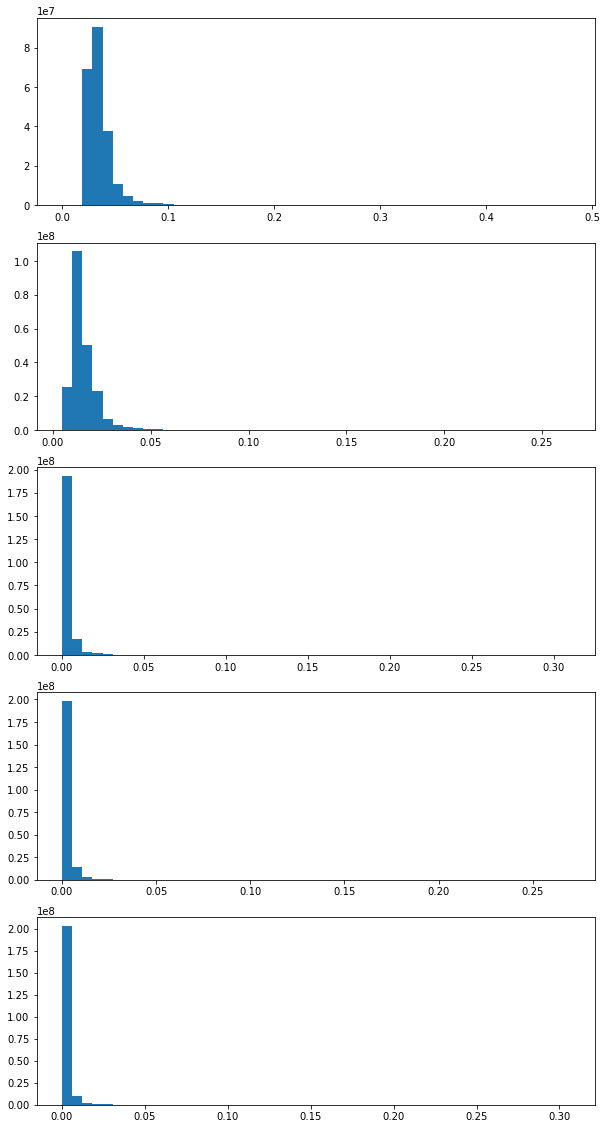

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(10,20))

for i in range(0,5):
    ax[i].hist(all_imgs[:,i].flatten(), bins=50)
    #ax[i].set_xlim(0,0.060)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

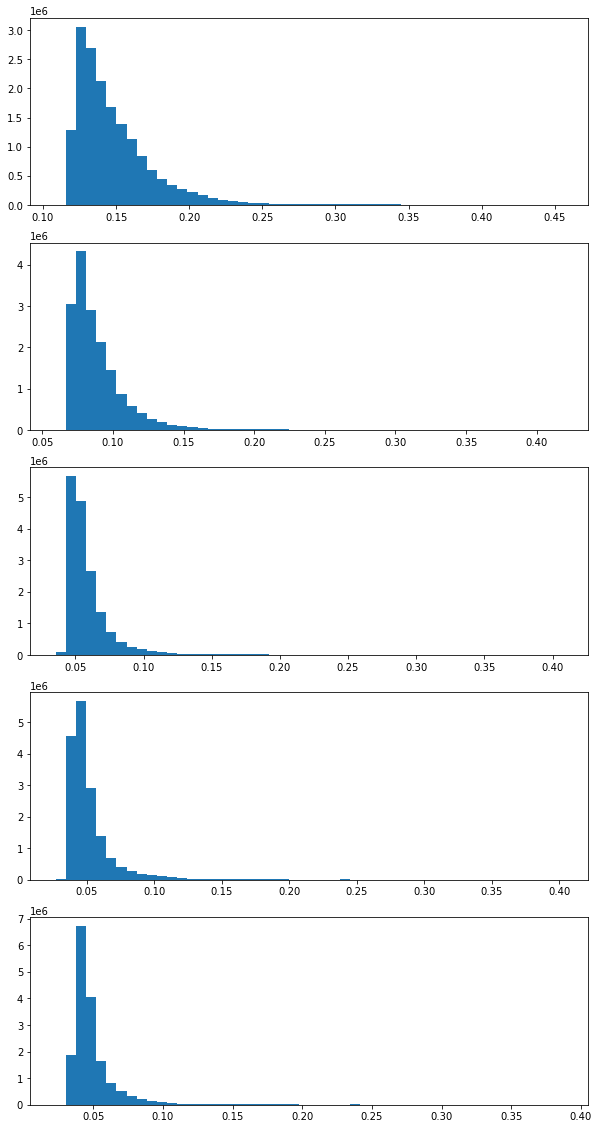

In [34]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(5,1, figsize=(10,20))

for i in range(0,5):
    ax[i].hist(all_sky_imgs[:,i].flatten(), bins=50)
    #ax[i].set_xlim(0,0.060)
    #im = ax[i].imshow(all_imgs[0,i])
    #fig.colorbar(im, ax=ax[i])

### Cut off the bright outliers

In [20]:
# ignoring any zero values find the lowest 10% of the NIR band
list_of_lowest = []

In [21]:
mean_lowest = []
list_of_spectra = []

for i in range(0,all_imgs.shape[0]):
#for i in range(0,40):
    nir_idx = 4
    # choose the percent to sort
    spectra = []
    lowest_percent = .65
    num_to_sort = int(all_imgs[i,nir_idx].size * lowest_percent)
    #print('sorting ', num_to_sort)
    nir_idx = 4
    
    # efficiently sort the array
    flat_array = all_imgs[i,nir_idx].flatten()
    flat_array[flat_array == 0 ] = 1
    #flat_array[flat_array < 0.0035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    #plt.hist(flat_array[idx], density=True, bins=60)
    mean_of_subset_band = np.mean(flat_array[idx])
    mean_lowest.append(mean_of_subset_band)
    #plt.axvline(x=mean_of_subset_band)
    #plt.xlim(0,0.005)
    for img_idx in range(0,5):
        spectra.append(np.mean(all_imgs[i,img_idx].flatten()[idx]))
    list_of_spectra.append(spectra)
list_of_lowest.append(mean_lowest)

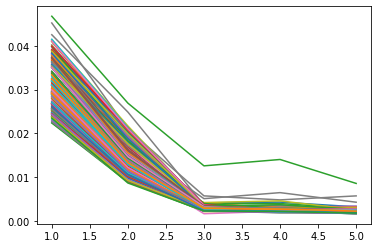

In [22]:
for spectra in list_of_spectra:
    plt.plot(range(1,6), spectra)

In [23]:
# not sure at all we should be using NIR for this

mean_lowest = []
list_of_sky_spectra = []

for capture_num in range(0,len(skyimgset.captures)):
    sky_spectra = []
#for capture_num in [-1]:
    lowest_percent = 0.65
    num_to_sort = int(skyimgset.captures[capture_num].images[0].undistorted_reflectance().size * lowest_percent)
    print('sorting ', num_to_sort)
    nir_idx = seaimgset.captures[capture_num].band_names_lower().index('nir')
    
    # efficiently sort the array
    flat_array = skyimgset.captures[capture_num].images[nir_idx].undistorted_reflectance().flatten()
    flat_array[flat_array == 0 ] = 1
    #flat_array[flat_array < 0.035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    plt.hist(flat_array[idx], density=True, bins=60)
    mean_lowest.append(np.mean(flat_array[idx]))
    for img_idx in range(0,5):
        sky_spectra.append(np.mean(skyimgset.captures[capture_num].images[img_idx].undistorted_reflectance().flatten()[idx]))
    list_of_sky_spectra.append(sky_spectra)

NameError: name 'skyimgset' is not defined

In [24]:
mean_lowest = []
list_of_sky_spectra = []

for i in range(0,all_sky_imgs.shape[0]):
#for i in range(0,40):
    nir_idx = 4
    # choose the percent to sort
    spectra = []
    lowest_percent = .65
    num_to_sort = int(all_sky_imgs[i,nir_idx].size * lowest_percent)
    #print('sorting ', num_to_sort)
    nir_idx = 4
    
    # efficiently sort the array
    flat_array = all_sky_imgs[i,nir_idx].flatten()
    flat_array[flat_array == 0 ] = 1
    #flat_array[flat_array < 0.0035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    #plt.hist(flat_array[idx], density=True, bins=60)
    mean_of_subset_band = np.mean(flat_array[idx])
    mean_lowest.append(mean_of_subset_band)
    #plt.axvline(x=mean_of_subset_band)
    #plt.xlim(0,0.005)
    for img_idx in range(0,5):
        spectra.append(np.mean(all_sky_imgs[i,img_idx].flatten()[idx]))
    list_of_sky_spectra.append(spectra)

In [25]:
len(list_of_sky_spectra)

14

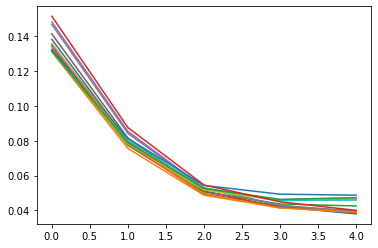

In [26]:
for ss in list_of_sky_spectra:
    plt.plot(range(0,5), ss)

In [624]:
seaimgset.captures[capture_num].band_names_lower()

['blue', 'green', 'red', 'nir', 'red edge']

In [ ]:
mean_lowest = []
list_of_spectra = []

for capture_num in range(0,len(seaimgset.captures)):
#for capture_num in [0,1,2,3,4,5,11]:
    spectra = []
    lowest_percent = .65
    num_to_sort = int(seaimgset.captures[capture_num].images[0].undistorted_reflectance(panel_irradiance[0]).size * lowest_percent)
    #print('sorting ', num_to_sort)
    nir_idx = seaimgset.captures[capture_num].band_names_lower().index('red edge')
    
    # efficiently sort the array
    flat_array = seaimgset.captures[capture_num].images[nir_idx].undistorted_reflectance(panel_irradiance[nir_idx]).flatten()
    flat_array[flat_array == 0 ] = 1
    #flat_array[flat_array < 0.0035 ] = 1
    idx = np.argpartition(flat_array, num_to_sort)[:num_to_sort]
    
    #plt.hist(flat_array[idx], density=True, bins=60)
    mean_lowest.append(np.mean(flat_array[idx]))
    for img_idx in range(0,5):
        spectra.append(np.mean(seaimgset.captures[capture_num].images[img_idx].undistorted_reflectance(panel_irradiance[img_idx]).flatten()[idx]))
    list_of_spectra.append(spectra)
#list_of_lowest.append(mean_lowest)

In [ ]:
for spectra in list_of_spectra:
    plt.plot(seaimgset.captures[0].band_names_lower(), spectra)

In [28]:
np.mean(list_of_sky_spectra,axis=0)

array([0.13725489, 0.08035719, 0.05163286, 0.04398001, 0.04221193])

In [29]:
wind = 5
sky_spectra = np.mean(list_of_sky_spectra,axis=0)
water_leaving_spectra = []
for water_spec in list_of_spectra:
    water_leaving = np.array(water_spec) - np.array(sky_spectra) * (0.0256 + 0.00039 * wind + 0.000034 * wind * wind)
    water_leaving_spectra.append(water_leaving)

In [30]:
len(water_leaving_spectra)

183

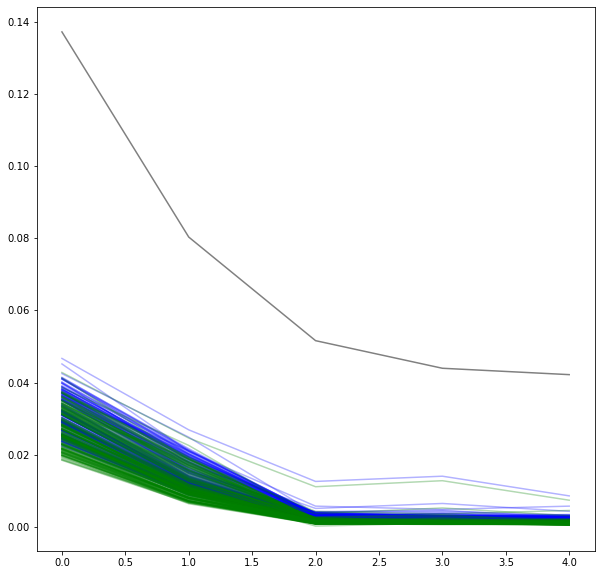

In [31]:
fig, ax = plt.subplots(figsize=(10,10))

for spectra in list_of_spectra:
    ax.plot(range(0,5), spectra, color='blue', alpha=0.3)
    
for spectra in water_leaving_spectra:
    ax.plot(range(0,5), spectra, color='green', alpha=0.3)
    
ax.plot(range(0,5), sky_spectra, color='grey')
#ax.plot(seaimgset.captures[capture_num].band_names_lower(), [0.13079345, 0.08020303, 0.05103283, 0.04054285, 0.04573154])

In [32]:
def L2chlor_a(Rrs443, Rrs488, Rrs547, Rrs555, Rrs667):
    ''' Use weighted MODIS Aqua bands to calculate chlorophyll concentration
    using oc3m blended algorithm with CI (Hu et al. 2012) '''

    thresh = [0.15, 0.20]
    a0 = 0.2424
    a1 = -2.7423
    a2 = 1.8017
    a3 = 0.0015
    a4 = -1.2280

    ci1 = -0.4909
    ci2 = 191.6590
    
    if Rrs443 > Rrs488:
        Rrsblue = Rrs443
    else:
        Rrsblue = Rrs488

    log10chl = a0 + a1 * (np.log10(Rrsblue / Rrs547)) \
        + a2 * (np.log10(Rrsblue / Rrs547))**2 \
            + a3 * (np.log10(Rrsblue / Rrs547))**3 \
                + a4 * (np.log10(Rrsblue / Rrs547))**4

    oc3m = np.power(10, log10chl)

    CI = Rrs555 - ( Rrs443 + (555 - 443)/(667 - 443) * \
        (Rrs667 -Rrs443) )
        
    ChlCI = 10** (ci1 + ci2*CI)

    if ChlCI <= thresh[0]:
        chlor_a = ChlCI
    elif ChlCI > thresh[1]:
        chlor_a = oc3m
    else:
        chlor_a = oc3m * (ChlCI-thresh[0]) / (thresh[1]-thresh[0]) +\
            ChlCI * (thresh[1]-ChlCI) / (thresh[1]-thresh[0])

    return chlor_a


In [33]:
chla_list = []
for spectra in water_leaving_spectra:
    chla = L2chlor_a(spectra[0],spectra[0],spectra[1],spectra[1],spectra[2])
    chla_list.append(chla)

In [34]:
chla_list

[0.06607703339462129,
 0.06014538805959294,
 0.1745291154546848,
 0.0839689364552949,
 0.19268766320342448,
 0.08519641393862135,
 0.0670664707110537,
 0.22647865026649566,
 0.054111732895272664,
 0.05448039158330187,
 0.0530148647259221,
 0.06362198803613696,
 0.05547084726197068,
 0.06781152152908593,
 0.34450725707315416,
 0.0679073656286701,
 0.07439040741407016,
 0.059699709841282554,
 0.05907430695422707,
 0.05427825510153961,
 0.05816149566715658,
 0.08248957222866968,
 0.0871540329536401,
 0.055298807995011794,
 0.060360887076846004,
 0.06659246163986363,
 0.05616623129996226,
 0.06218221379058535,
 0.07855372411555657,
 0.10070258441091588,
 0.04962458257281501,
 0.060691088677945676,
 0.05138145088091254,
 0.0631372138492058,
 0.3589598934238005,
 0.06580191784364979,
 0.06409141583152422,
 0.38944323523485075,
 0.05433532914749153,
 0.07375197594207315,
 0.06878493305058019,
 0.06379590050672482,
 0.06408208848042997,
 0.33748843141651513,
 0.07492592299020723,
 0.0534527479

In [35]:
img_metadata[0]

{'Latitude': 34.247825,
 'Longitude': -76.3846138888889,
 'Altitude': 6.3,
 'UTC-Time': '16:33:28',
 'Date': '09/13/2020'}

In [36]:
lats = []
lons = []
for idx, item in enumerate(img_metadata):
    lats.append(item['Latitude'])
    if item['Latitude'] < 33:
        print(idx)
    lons.append(item['Longitude'])
lats[0], lons[0]

67
147


(34.247825, -76.3846138888889)

In [37]:
from datetime import datetime
chla_dates = []
for im in img_metadata:
    date_time_str = im['Date'] + ' ' + im['UTC-Time']

    date_time_obj = datetime.strptime(date_time_str, '%m/%d/%Y %H:%M:%S')
    chla_dates.append(date_time_obj)

In [38]:
del lats[67]
del lats[146]
del lats[147]
del lons[67]
del lons[146]
del lons[147]
del chla_list[67]
del chla_list[146]
del chla_list[147]
del chla_dates[67]
del chla_dates[146]
del chla_dates[147]

In [39]:
for idx, lat in enumerate(lons):
    if lat > -65:
        print(idx)

In [40]:
lats[147]

34.24250555555555

In [41]:
len(chla_dates)

180

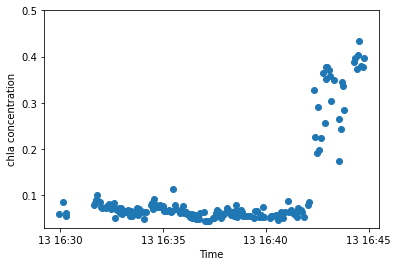

In [42]:
plt.scatter(chla_dates, chla_list)
plt.ylim(0.03,.5)
plt.ylabel('chla concentration')
plt.xlabel('Time')
#plt.xlim(34.23, max(lats))
#N=6
#running_avg = np.convolve(chla_list, np.ones((N,))/N, mode='valid')
#plt.plot(lons[5:], running_avg)
plt.savefig('chla_across_time.png', dpi=300)

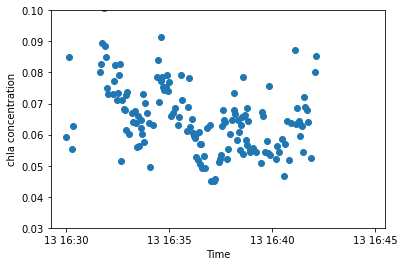

In [43]:
plt.scatter(chla_dates, chla_list)
plt.ylim(0.03,.1)
plt.ylabel('chla concentration')
plt.xlabel('Time')
#plt.xlim(34.23, max(lats))
#N=6
#running_avg = np.convolve(chla_list, np.ones((N,))/N, mode='valid')
#plt.plot(lons[5:], running_avg)
plt.savefig('chla_across_time_zoomed.png', dpi=300)

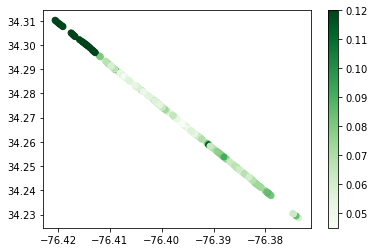

In [44]:
import matplotlib
plt.scatter(lons, lats, c=chla_list, cmap='Greens', vmax=0.12)
plt.colorbar()
plt.savefig('chla_across_space.png', dpi=300)
plt.show()

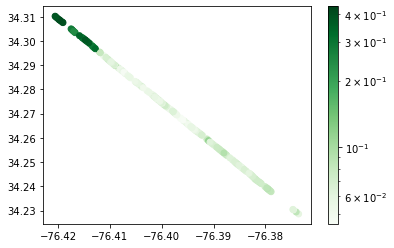

In [45]:
import matplotlib
plt.scatter(lons, lats, c=chla_list, cmap='Greens', norm=matplotlib.colors.LogNorm())
plt.colorbar()
plt.show()

In [46]:
! ls data/130920_shearwatergulf_rededge

0005SET  0007SET  0009SET  0011SET  0013SET  Data every 1 min_001.csv
0006SET  0008SET  0010SET  0012SET  0014SET  MetaDataSensorDescription_001.CSV


In [47]:
import pandas as pd
df = pd.read_csv("data/130920_shearwatergulf_rededge/Data every 1 min_001.csv")
df

,Date,Time,SW-ZDA-Year,SW-ZDA-Month,SW-ZDA-Day,SW-ZDA-Time,SW-GGA-Lat,SW-GGA-NorS,SW-GGA-Long,SW-GGA-EorW,...,SW-Weather-HumidRel-%,SW-Wind-WindSpeedRel,SW-Wind-WindAngleRel,TrueWind-DRV-SPEED,TrueWind-DRV-DIRECTION,TSG--temp-SBE38,TSG--sal,SW-Depth-DBT-Depth below transducer (m),DepthOverall-DRV-VALUE,Unnamed: 24
0,09/13/2020,11:47:46,2020,9,13,114907.70,3443.0548,N,7640.2341,W,...,89.4,9.39,26.40,9.38,40.19,26.8799,16.5905,5.50,6.50,NaN
1,09/13/2020,11:48:46,2020,9,13,115007.70,3443.0549,N,7640.2341,W,...,89.5,9.99,22.10,9.99,35.71,26.8796,16.5906,5.48,6.48,NaN
2,09/13/2020,11:49:46,2020,9,13,115107.69,3443.0549,N,7640.2341,W,...,89.4,12.79,17.40,13.08,30.48,26.8796,16.5906,5.48,6.48,NaN
3,09/13/2020,11:50:46,2020,9,13,115207.70,3443.0548,N,7640.2338,W,...,89.3,11.39,23.10,11.39,36.70,26.8793,16.5686,5.47,6.47,NaN
4,09/13/2020,11:51:46,2020,9,13,115308.00,3443.0547,N,7640.2339,W,...,89.1,13.39,18.90,13.40,32.57,26.8791,16.5677,5.47,6.47,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,09/13/2020,18:54:49,2020,9,13,185613.68,3443.0544,N,7640.2331,W,...,80.2,3.50,110.29,4.08,120.70,27.9084,18.0992,5.87,6.87,NaN
428,09/13/2020,18:55:49,2020,9,13,185711.68,3443.0541,N,7640.2330,W,...,80.4,3.50,63.70,3.50,78.30,27.9218,18.1040,5.88,6.88,NaN
429,09/13/2020,18:56:49,2020,9,13,185811.67,3443.0546,N,7640.2328,W,...,79.9,1.59,82.70,1.59,97.41,27.9358,18.1071,5.88,6.88,NaN
430,09/13/2020,18:57:49,2020,9,13,185911.67,3443.0539,N,7640.2326,W,...,79.9,2.99,45.80,2.99,59.80,27.9489,18.1082,5.94,6.94,NaN


In [80]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

In [81]:
df

,Date,Time,SW-ZDA-Year,SW-ZDA-Month,SW-ZDA-Day,SW-ZDA-Time,SW-GGA-Lat,SW-GGA-NorS,SW-GGA-Long,SW-GGA-EorW,...,SW-Wind-WindAngleRel,TrueWind-DRV-SPEED,TrueWind-DRV-DIRECTION,TSG--temp-SBE38,TSG--sal,SW-Depth-DBT-Depth below transducer (m),DepthOverall-DRV-VALUE,Unnamed: 24,lon,lat
0,09/13/2020,11:47:46,2020,9,13,114907.70,3443.0548,N,7640.2341,W,...,26.40,9.38,40.19,26.8799,16.5905,5.50,6.50,NaN,-76.670568,34.717580
1,09/13/2020,11:48:46,2020,9,13,115007.70,3443.0549,N,7640.2341,W,...,22.10,9.99,35.71,26.8796,16.5906,5.48,6.48,NaN,-76.670568,34.717582
2,09/13/2020,11:49:46,2020,9,13,115107.69,3443.0549,N,7640.2341,W,...,17.40,13.08,30.48,26.8796,16.5906,5.48,6.48,NaN,-76.670568,34.717582
3,09/13/2020,11:50:46,2020,9,13,115207.70,3443.0548,N,7640.2338,W,...,23.10,11.39,36.70,26.8793,16.5686,5.47,6.47,NaN,-76.670563,34.717580
4,09/13/2020,11:51:46,2020,9,13,115308.00,3443.0547,N,7640.2339,W,...,18.90,13.40,32.57,26.8791,16.5677,5.47,6.47,NaN,-76.670565,34.717578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,09/13/2020,18:54:49,2020,9,13,185613.68,3443.0544,N,7640.2331,W,...,110.29,4.08,120.70,27.9084,18.0992,5.87,6.87,NaN,-76.670552,34.717573
428,09/13/2020,18:55:49,2020,9,13,185711.68,3443.0541,N,7640.2330,W,...,63.70,3.50,78.30,27.9218,18.1040,5.88,6.88,NaN,-76.670550,34.717568
429,09/13/2020,18:56:49,2020,9,13,185811.67,3443.0546,N,7640.2328,W,...,82.70,1.59,97.41,27.9358,18.1071,5.88,6.88,NaN,-76.670547,34.717577
430,09/13/2020,18:57:49,2020,9,13,185911.67,3443.0539,N,7640.2326,W,...,45.80,2.99,59.80,27.9489,18.1082,5.94,6.94,NaN,-76.670543,34.717565


In [185]:
img_metadata

[{'Latitude': 34.247825,
  'Longitude': -76.3846138888889,
  'Altitude': 6.3,
  'UTC-Time': '16:33:28',
  'Date': '09/13/2020'},
 {'Latitude': 34.27248055555555,
  'Longitude': -76.39883888888889,
  'Altitude': 1.4,
  'UTC-Time': '16:37:58',
  'Date': '09/13/2020'},
 {'Latitude': 34.303666666666665,
  'Longitude': -76.41685277777778,
  'Altitude': 3.3,
  'UTC-Time': '16:43:35',
  'Date': '09/13/2020'},
 {'Latitude': 34.25306388888889,
  'Longitude': -76.3876138888889,
  'Altitude': 8.5,
  'UTC-Time': '16:34:27',
  'Date': '09/13/2020'},
 {'Latitude': 34.29742777777778,
  'Longitude': -76.41318333333334,
  'Altitude': 2,
  'UTC-Time': '16:42:29',
  'Date': '09/13/2020'},
 {'Latitude': 34.29541944444444,
  'Longitude': -76.4120138888889,
  'Altitude': 2.8,
  'UTC-Time': '16:42:7',
  'Date': '09/13/2020'},
 {'Latitude': 34.246183333333335,
  'Longitude': -76.38366944444445,
  'Altitude': 6.1,
  'UTC-Time': '16:33:10',
  'Date': '09/13/2020'},
 {'Latitude': 34.29711666666667,
  'Longitude'

In [200]:
len(chla_list)

180

<AxesSubplot:>

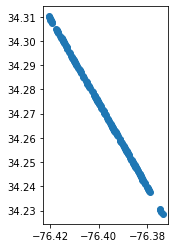

In [82]:
import geopandas as gpd
chla_df = pd.DataFrame(
    {'chla': chla_list,
     'Latitude': lats,
     'Longitude': lons,
     'time' : chla_dates})

chla_gdf = gpd.GeoDataFrame(
    chla_df, geometry=gpd.points_from_xy(chla_df.Longitude, chla_df.Latitude))
chla_gdf.plot()

<AxesSubplot:>

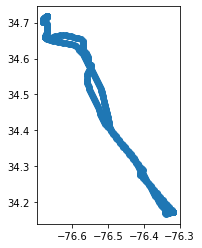

In [83]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.plot()

In [84]:
gdf

date_time_strs = gdf['Date'] + ' ' + gdf['Time']

gdf['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]

In [93]:
chla_gdf.head()

,chla,Latitude,Longitude,time,geometry
0,0.066077,34.247825,-76.384614,2020-09-13 16:33:28,POINT (-76.38461 34.24782)
1,0.060145,34.272481,-76.398839,2020-09-13 16:37:58,POINT (-76.39884 34.27248)
2,0.174529,34.303667,-76.416853,2020-09-13 16:43:35,POINT (-76.41685 34.30367)
3,0.083969,34.253064,-76.387614,2020-09-13 16:34:27,POINT (-76.38761 34.25306)
4,0.192688,34.297428,-76.413183,2020-09-13 16:42:29,POINT (-76.41318 34.29743)


In [98]:
chla_gdf.time

0      2020-09-13 16:33:28
1      2020-09-13 16:37:58
2      2020-09-13 16:43:35
3      2020-09-13 16:34:27
4      2020-09-13 16:42:29
              ...         
175    2020-09-13 16:38:35
176    2020-09-13 16:39:05
177    2020-09-13 16:35:00
178    2020-09-13 16:38:46
179    2020-09-13 16:33:01
Name: time, Length: 180, dtype: object

In [99]:
chla_gdf.time = chla_gdf.time.astype(str)
chla_gdf.to_file('uas_data.shp')

In [90]:
chla_gdf.to_file('uas_data.shp')

DriverSupportError: ESRI Shapefile does not support datetime fields

In [91]:
chla_gdf.to_file('uas_data.geojson')

DriverSupportError: ESRI Shapefile does not support datetime fields

In [92]:
gdf.to_file('boat_data.shp')

DriverSupportError: ESRI Shapefile does not support datetime fields

In [86]:
gdf

,Date,Time,SW-ZDA-Year,SW-ZDA-Month,SW-ZDA-Day,SW-ZDA-Time,SW-GGA-Lat,SW-GGA-NorS,SW-GGA-Long,SW-GGA-EorW,...,TrueWind-DRV-DIRECTION,TSG--temp-SBE38,TSG--sal,SW-Depth-DBT-Depth below transducer (m),DepthOverall-DRV-VALUE,Unnamed: 24,lon,lat,geometry,datetime
0,09/13/2020,11:47:46,2020,9,13,114907.70,3443.0548,N,7640.2341,W,...,40.19,26.8799,16.5905,5.50,6.50,NaN,-76.670568,34.717580,POINT (-76.67057 34.71758),2020-09-13 11:47:46
1,09/13/2020,11:48:46,2020,9,13,115007.70,3443.0549,N,7640.2341,W,...,35.71,26.8796,16.5906,5.48,6.48,NaN,-76.670568,34.717582,POINT (-76.67057 34.71758),2020-09-13 11:48:46
2,09/13/2020,11:49:46,2020,9,13,115107.69,3443.0549,N,7640.2341,W,...,30.48,26.8796,16.5906,5.48,6.48,NaN,-76.670568,34.717582,POINT (-76.67057 34.71758),2020-09-13 11:49:46
3,09/13/2020,11:50:46,2020,9,13,115207.70,3443.0548,N,7640.2338,W,...,36.70,26.8793,16.5686,5.47,6.47,NaN,-76.670563,34.717580,POINT (-76.67056 34.71758),2020-09-13 11:50:46
4,09/13/2020,11:51:46,2020,9,13,115308.00,3443.0547,N,7640.2339,W,...,32.57,26.8791,16.5677,5.47,6.47,NaN,-76.670565,34.717578,POINT (-76.67056 34.71758),2020-09-13 11:51:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,09/13/2020,18:54:49,2020,9,13,185613.68,3443.0544,N,7640.2331,W,...,120.70,27.9084,18.0992,5.87,6.87,NaN,-76.670552,34.717573,POINT (-76.67055 34.71757),2020-09-13 18:54:49
428,09/13/2020,18:55:49,2020,9,13,185711.68,3443.0541,N,7640.2330,W,...,78.30,27.9218,18.1040,5.88,6.88,NaN,-76.670550,34.717568,POINT (-76.67055 34.71757),2020-09-13 18:55:49
429,09/13/2020,18:56:49,2020,9,13,185811.67,3443.0546,N,7640.2328,W,...,97.41,27.9358,18.1071,5.88,6.88,NaN,-76.670547,34.717577,POINT (-76.67055 34.71758),2020-09-13 18:56:49
430,09/13/2020,18:57:49,2020,9,13,185911.67,3443.0539,N,7640.2326,W,...,59.80,27.9489,18.1082,5.94,6.94,NaN,-76.670543,34.717565,POINT (-76.67054 34.71757),2020-09-13 18:57:49


In [180]:
gdf.crs

<AxesSubplot:>

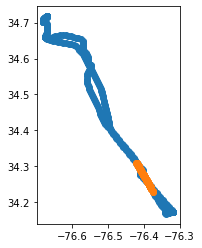

In [88]:
fig, ax = plt.subplots()

gdf.plot(ax=ax)
chla_gdf.plot(ax=ax)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


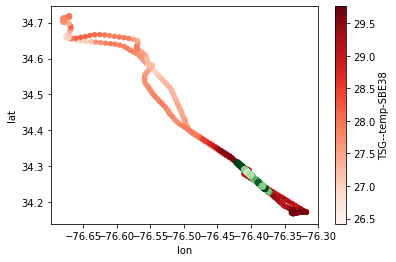

In [89]:
fig, ax = plt.subplots()
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax)
ax.scatter(lons, lats, c=chla_list, cmap='Greens', vmax=0.08)
#lt.savefig('geolocation_error.png', dpi=300)
fig.show()

In [238]:
chla_gdf

,chla,Latitude,Longitude,time,geometry
0,0.066077,34.247825,-76.384614,2020-09-13 16:33:28,POINT (-76.38461 34.24782)
1,0.060145,34.272481,-76.398839,2020-09-13 16:37:58,POINT (-76.39884 34.27248)
2,0.174529,34.303667,-76.416853,2020-09-13 16:43:35,POINT (-76.41685 34.30367)
3,0.083969,34.253064,-76.387614,2020-09-13 16:34:27,POINT (-76.38761 34.25306)
4,0.192688,34.297428,-76.413183,2020-09-13 16:42:29,POINT (-76.41318 34.29743)
...,...,...,...,...,...
175,0.053861,34.275931,-76.400822,2020-09-13 16:38:35,POINT (-76.40082 34.27593)
176,0.055544,34.278764,-76.402414,2020-09-13 16:39:05,POINT (-76.40241 34.27876)
177,0.076916,34.256069,-76.389344,2020-09-13 16:35:00,POINT (-76.38934 34.25607)
178,0.056803,34.276942,-76.401364,2020-09-13 16:38:46,POINT (-76.40136 34.27694)


<AxesSubplot:>

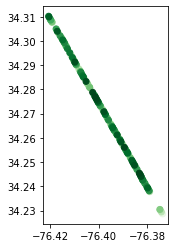

In [243]:
chla_gdf.plot( cmap='Greens', vmax=0.08)

In [259]:
chla_gdf['time'].min()

Timestamp('2020-09-13 16:29:58')

In [265]:
datetime.strptime('2020-09-13 16:44:46', '%Y-%m-%d %H:%M:%S')

datetime.datetime(2020, 9, 13, 16, 44, 46)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if sys.path[0] == '':


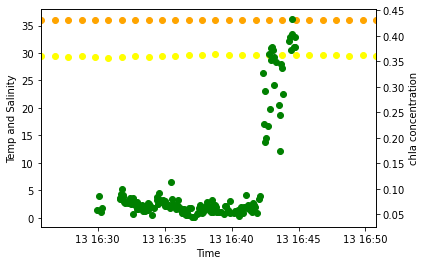

In [291]:
fig, ax = plt.subplots()

ax.set_xlim(datetime.strptime('2020-09-13 16:25:46', '%Y-%m-%d %H:%M:%S'), datetime.strptime('2020-09-13 16:50:46', '%Y-%m-%d %H:%M:%S'))

ax2 = ax.twinx()
ax.set_ylabel('Temp and Salinity')
ax.set_xlabel('Time')
ax2.set_ylabel('chla concentration')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--temp-SBE38'], color='yellow')
ax.scatter(x=gdf['datetime'], y=gdf['TSG--sal'], color='orange')
ax2.scatter(x=chla_gdf['time'], y=chla_gdf['chla'], color='green')
fig.show()
plt.savefig('chla_s_t.png', dpi=300)

In [ ]:
fig, ax = plt.subplots()
df.plot(kind='scatter',x='lon', y='lat', c='TSG--temp-SBE38', cmap='Reds',ax=ax)
ax.scatter(lons, lats, c=chla_list, cmap='Greens', vmax=0.08)
plt.savefig('geolocation_error.png', dpi=300)
fig.show()

<AxesSubplot:xlabel='lon', ylabel='lat'>

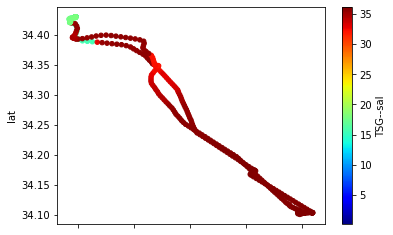

In [141]:
df.plot(kind='scatter',x='lon', y='lat', c='TSG--sal', cmap='jet')

<AxesSubplot:xlabel='Time', ylabel='TSG--sal'>

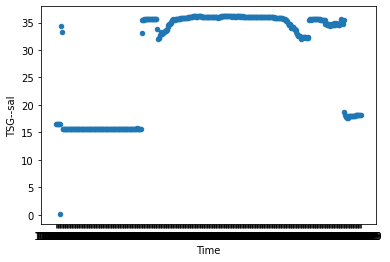

In [144]:
df.plot(kind='scatter',x='Time', y='TSG--sal', cmap='jet')

<AxesSubplot:xlabel='Time', ylabel='DepthOverall-DRV-VALUE'>

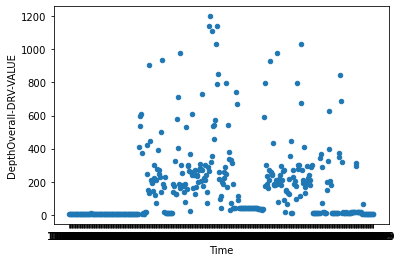

In [143]:
df.plot(kind='scatter',x='Time', y='DepthOverall-DRV-VALUE', cmap='Blues')

<AxesSubplot:xlabel='lon', ylabel='lat'>

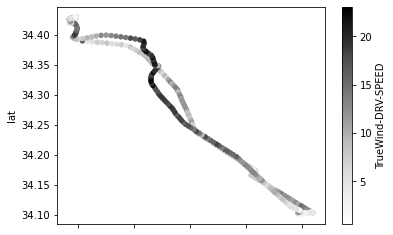

In [137]:
df.plot(kind='scatter',x='lon', y='lat', c='TrueWind-DRV-SPEED', cmap='Greys')

### Calculate Chl-a Across the Whole Image

In [331]:
full_sea_img = []
for img_idx in range(0,5):
    full_sea_img.append(seaimgset.captures[-1].images[img_idx].undistorted_reflectance().flatten())
full_sea_img = np.array(full_sea_img)

In [337]:
sky_rad_correction = np.reshape(np.array(sky_spectra) * (0.0256 + 0.00039 * wind + 0.000034 * wind * wind), (5,1))
water_leaving = full_sea_img - sky_rad_correction

In [339]:
water_leaving.shape

(5, 1228800)

In [364]:
chlas = []
for i in range(water_leaving.shape[-1]):
    chlas.append(L2chlor_a(water_leaving[0,i],water_leaving[0,i],water_leaving[1,i],water_leaving[1,i],water_leaving[2,i]))

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


In [451]:
chlas = np.array(chlas)

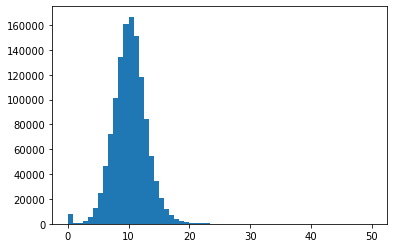

In [452]:
plt.hist(chlas, range=(0,50), bins=60)
plt.show()

In [453]:
np.nanmax(chlas)

4365.122024934244

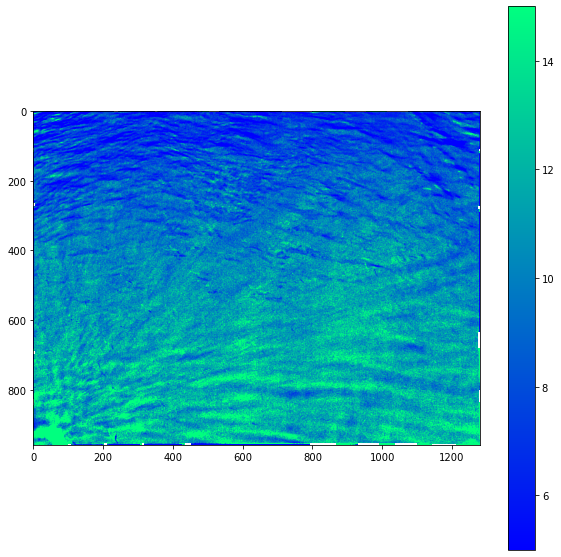

In [454]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.reshape(chlas,(960, 1280)), vmin=5, vmax=15, cmap='winter')
fig.colorbar(im)

In [633]:
selected_pix = np.zeros(flat_array.shape[0], dtype=np.int)
selected_pix[idx] = 1

In [634]:
np.unique(selected_pix)

array([0, 1])

In [635]:
selected_pix[flat_array == 0 ] = 0
selected_pix[flat_array < 0.0035 ] = 0
selected_pix[flat_array > 1 ] = 0

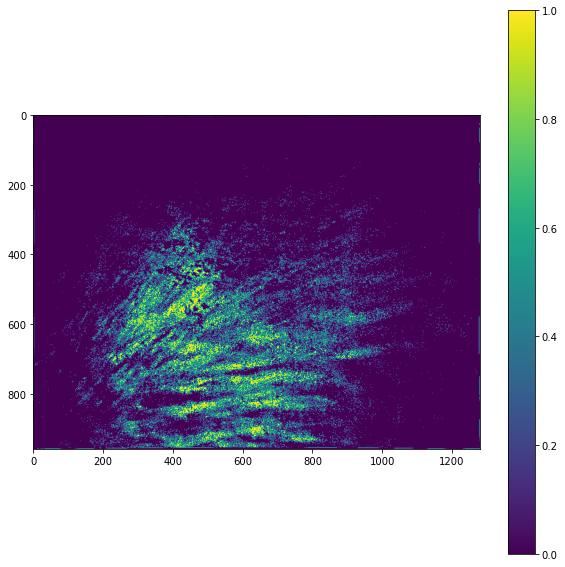

In [636]:
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(np.reshape(selected_pix,(960, 1280)))
fig.colorbar(im)

In [637]:
chlas

array([  1.06918105,   4.25718288,   7.39999911, ..., 102.4735359 ,
       122.40470703,  84.21683414])

In [638]:
chla_pix = np.zeros(flat_array.shape[0])
chla_pix[idx] = chlas[idx]

In [639]:
chla_pix[chla_pix > 25] = 25
chla_pix[flat_array < 0.0035 ] = 0
chla_pix[flat_array > 1 ] = 0

In [640]:
chla_pix[chla_pix == 0] = np.nan

In [641]:
np.nanmax(chla_pix)

25.0

In [642]:
np.nanmedian(chla_pix)

11.357427156291521

<function matplotlib.pyplot.show(close=None, block=None)>

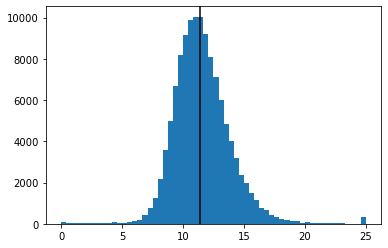

In [643]:
plt.hist(chla_pix, density=False, bins=60)
plt.axvline(x=np.nanmedian(chla_pix), color='black')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

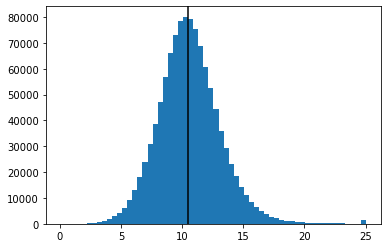

In [590]:
plt.hist(chla_pix, density=False, bins=60)
plt.axvline(x=np.nanmedian(chla_pix), color='black')
plt.show

In [622]:
np.count_nonzero(~np.isnan(chla_pix)) / chla_pix.size

0.09963948567708333

<function matplotlib.pyplot.show(close=None, block=None)>

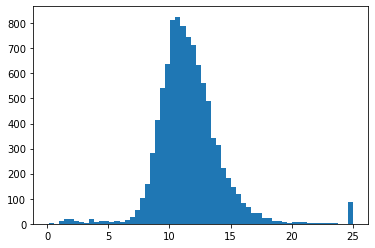

In [576]:
plt.hist(chla_pix, density=False, bins=60)
plt.show

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  after removing the cwd from sys.path.


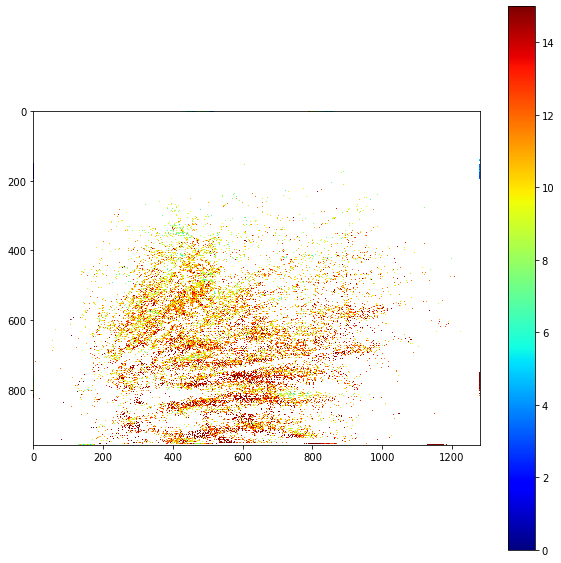

In [644]:
fig, ax = plt.subplots(figsize=(10,10))

cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)

im = ax.imshow(np.reshape(chla_pix,(960, 1280)), vmin=0, vmax=15, interpolation='nearest', cmap=cmap)
fig.colorbar(im)

/home/clifgray/anaconda3/envs/micasense/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  after removing the cwd from sys.path.


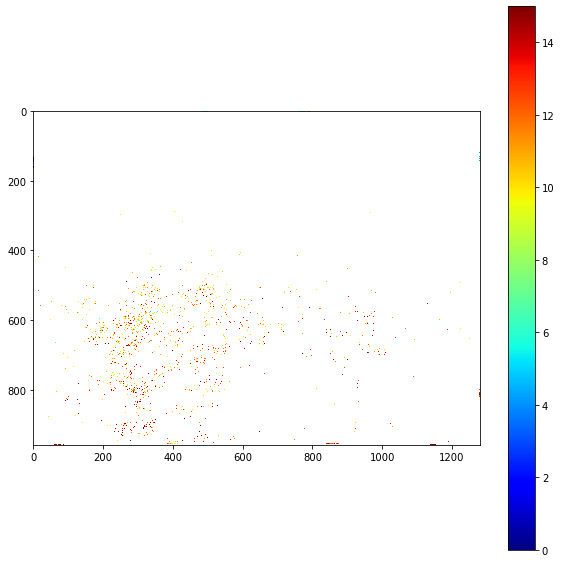

In [578]:
fig, ax = plt.subplots(figsize=(10,10))

cmap = matplotlib.cm.jet
cmap.set_bad('white',1.)

im = ax.imshow(np.reshape(chla_pix,(960, 1280)), vmin=0, vmax=15, interpolation='nearest', cmap=cmap)
fig.colorbar(im)